In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

2025-08-20 13:34:44.535023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755696884.893035      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755696884.989546      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_dir = "/kaggle/input/data-256-256-new/data_256_256_new"

In [3]:
df = pd.read_excel(f"{base_dir}/labels.xlsx")

# full file paths
df["filepath"] = df["id"].apply(lambda x: os.path.join(base_dir, x))
print(df.head())

                id label                                           filepath
0  Red/Red (1).jpg   Red  /kaggle/input/data-256-256-new/data_256_256_ne...
1  Red/Red (2).jpg   Red  /kaggle/input/data-256-256-new/data_256_256_ne...
2  Red/Red (3).jpg   Red  /kaggle/input/data-256-256-new/data_256_256_ne...
3  Red/Red (4).jpg   Red  /kaggle/input/data-256-256-new/data_256_256_ne...
4  Red/Red (5).jpg   Red  /kaggle/input/data-256-256-new/data_256_256_ne...


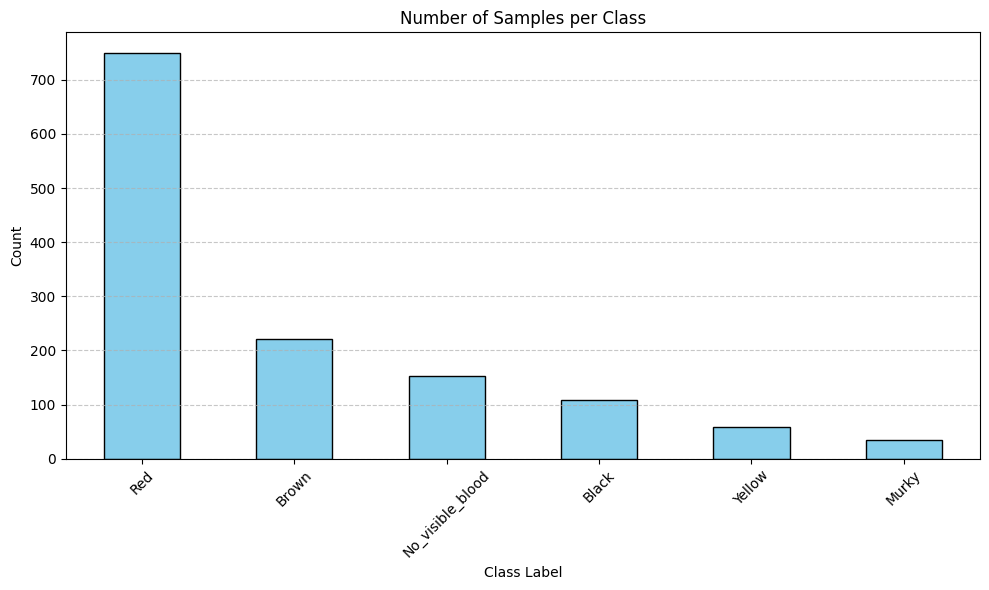

In [4]:
class_counts = df['label'].value_counts()
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Samples per Class')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Pre-Processing

In [5]:
print("Loading images...")
images = []
labels = []
for i, row in df.iterrows():
    try:
        img = load_img(row["filepath"], target_size=(256, 256))
        img_array = img_to_array(img) / 255.0  # normalize
        images.append(img_array)
        labels.append(row["label"])
        
        if (i + 1) % 100 == 0:
            print(f"Loaded {i + 1} images.")
    except Exception as e:
        print(f"Error loading {row['filepath']}: {e}")

Loading images...
Loaded 100 images.
Loaded 200 images.
Loaded 300 images.
Loaded 400 images.
Loaded 500 images.
Loaded 600 images.
Loaded 700 images.
Loaded 800 images.
Loaded 900 images.
Loaded 1000 images.
Loaded 1100 images.
Loaded 1200 images.
Loaded 1300 images.


In [6]:
images = np.array(images)
labels = np.array(labels)
print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")

Images shape: (1325, 256, 256, 3), Labels shape: (1325,)


In [7]:
# Encode labels
le = LabelEncoder()
labels_int = le.fit_transform(labels)
labels_onehot = to_categorical(labels_int)

print("Integer labels (first 5):", labels_int[:5])
print("One-hot labels (first 5):", labels_onehot[:5])
print("Classes:", le.classes_)

num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")

Integer labels (first 5): [4 4 4 4 4]
One-hot labels (first 5): [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]
Classes: ['Black' 'Brown' 'Murky' 'No_visible_blood' 'Red' 'Yellow']
Number of classes: 6


## Split

In [8]:
# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test, labels_temp, labels_test = train_test_split(
    images, labels_onehot, labels_int, 
    test_size=0.2, random_state=42, stratify=labels_int
)

In [9]:
X_train, X_val, y_train, y_val, labels_train, labels_val = train_test_split(
    X_temp, y_temp, labels_temp,
    test_size=0.25, random_state=42, stratify=labels_temp  
)

In [10]:
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (795, 256, 256, 3), (795, 6)
Validation set: (265, 256, 256, 3), (265, 6)
Test set: (265, 256, 256, 3), (265, 6)


## Model

In [11]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input

In [12]:
# classifier head for all models
def create_classifier_head(base_model, num_classes):
    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [13]:
def create_vgg_model(input_shape, num_classes):
    """Load pretrained InceptionV3 but make it fully trainable"""
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = True
    return create_classifier_head(base_model, num_classes)

In [14]:
model = create_vgg_model((256, 256, 3), num_classes)
model_name = "InceptionV3"

model.compile(
    optimizer=Adam(learning_rate=0.0001),  # lower learning rate since using pretrained weights
    loss='categorical_crossentropy',  
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1755696988.258010      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755696988.258641      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 6, 6, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,992,934 (87.71 MB)

 Trainable params: 22,954,406 (87.56 MB)

 Non-trainable params: 38,528 (150.50 KB)

In [16]:
# Callbacks
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

In [18]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

Epoch 1/30


I0000 00:00:1755697062.274455     106 service.cc:148] XLA service 0x7cc0b40abc10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755697062.276055     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755697062.276085     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755697067.673360     106 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755697097.473846     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.3357 - loss: 2.0148
Epoch 1: val_accuracy improved from -inf to 0.62642, saving model to best_model.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.3386 - loss: 2.0067 - val_accuracy: 0.6264 - val_loss: 1.0893
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.6865 - loss: 0.9623
Epoch 2: val_accuracy improved from 0.62642 to 0.70566, saving model to best_model.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.6868 - loss: 0.9616 - val_accuracy: 0.7057 - val_loss: 0.8847
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7681 - loss: 0.6326
Epoch 3: val_accuracy did not improve from 0.70566
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.7679 - loss: 0.6331 - val_accuracy: 0.6868 - val_loss: 0.8621
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8361 - loss: 0.4674
Epoch 4: val_accuracy improved from 0.70566 to 0.73208, saving model to best_model.h5
50/50 ━━━━

In [19]:
loss, accuracy = model.evaluate(X_train, y_train)
print(f"Train Accuracy: {accuracy*100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 412ms/step - accuracy: 0.9974 - loss: 0.0102
Train Accuracy: 99.62%


In [20]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.7625 - loss: 1.4869
Validation Accuracy: 76.98%


## Loss and Accuracy Matrices

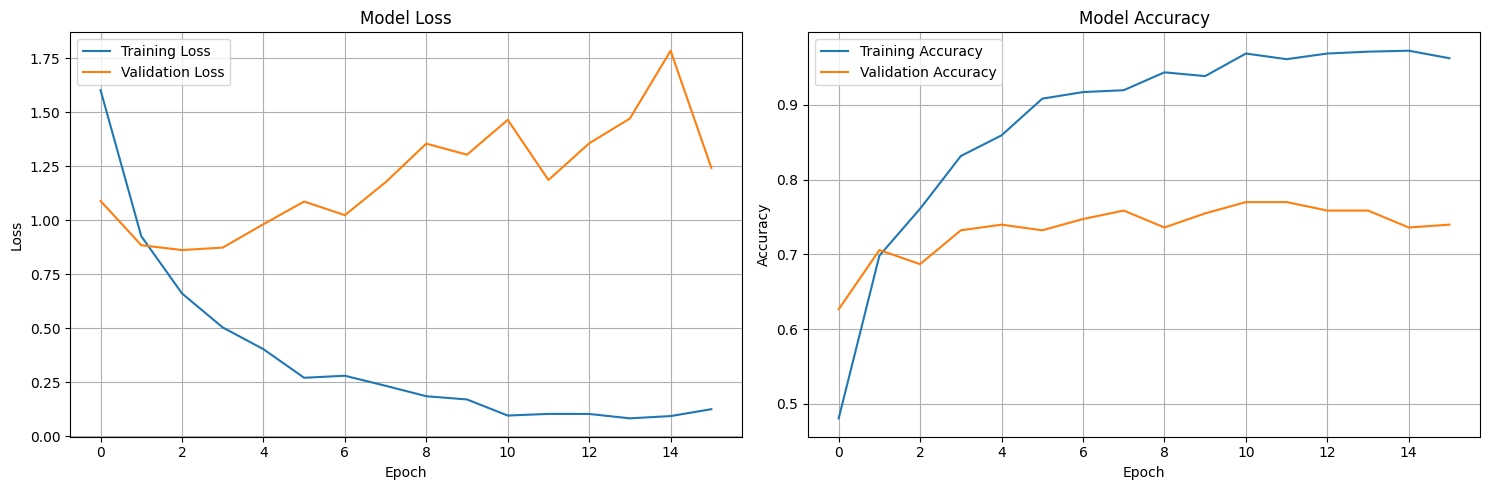

In [21]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Other Matrices

In [22]:
# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

In [23]:
train_preds = np.argmax(best_model.predict(X_train, batch_size=16), axis=1)
val_preds = np.argmax(best_model.predict(X_val, batch_size=16), axis=1)
test_preds = np.argmax(best_model.predict(X_test, batch_size=16), axis=1)

50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [24]:
y_train_int = np.argmax(y_train, axis=1)
y_val_int = np.argmax(y_val, axis=1)
y_test_int = np.argmax(y_test, axis=1)

In [25]:
train_accuracy = np.mean(y_train_int == train_preds)
val_accuracy = np.mean(y_val_int == val_preds)
test_accuracy = np.mean(y_test_int == test_preds)

print(f"\nFinal Results using Pretrained {model_name} with Focal Loss:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Final Results using Pretrained InceptionV3 with Focal Loss:
Train Accuracy: 0.9962
Validation Accuracy: 0.7698
Test Accuracy: 0.8075


In [26]:
# Detailed classification report for test set
print("\n=== Train Set Classification Report ===")
print(classification_report(y_train_int, train_preds, target_names=le.classes_))


=== Train Set Classification Report ===
                  precision    recall  f1-score   support

           Black       0.98      1.00      0.99        65
           Brown       0.99      1.00      1.00       134
           Murky       1.00      1.00      1.00        20
No_visible_blood       1.00      0.98      0.99        92
             Red       1.00      1.00      1.00       450
          Yellow       1.00      1.00      1.00        34

        accuracy                           1.00       795
       macro avg       1.00      1.00      1.00       795
    weighted avg       1.00      1.00      1.00       795



In [27]:
# Detailed classification report for test set
print("\n=== Validation Set Classification Report ===")
print(classification_report(y_val_int, val_preds, target_names=le.classes_))


=== Validation Set Classification Report ===
                  precision    recall  f1-score   support

           Black       0.00      0.00      0.00        22
           Brown       0.81      0.66      0.73        44
           Murky       0.33      0.14      0.20         7
No_visible_blood       0.86      0.80      0.83        30
             Red       0.78      0.94      0.85       150
          Yellow       0.69      0.75      0.72        12

        accuracy                           0.77       265
       macro avg       0.58      0.55      0.55       265
    weighted avg       0.71      0.77      0.73       265



In [28]:
# Detailed classification report for test set
print("\n=== Test Set Classification Report ===")
print(classification_report(y_test_int, test_preds, target_names=le.classes_))


=== Test Set Classification Report ===
                  precision    recall  f1-score   support

           Black       0.50      0.18      0.27        22
           Brown       0.81      0.80      0.80        44
           Murky       0.50      0.29      0.36         7
No_visible_blood       0.96      0.90      0.93        30
             Red       0.83      0.93      0.87       150
          Yellow       0.50      0.58      0.54        12

        accuracy                           0.81       265
       macro avg       0.68      0.61      0.63       265
    weighted avg       0.79      0.81      0.79       265



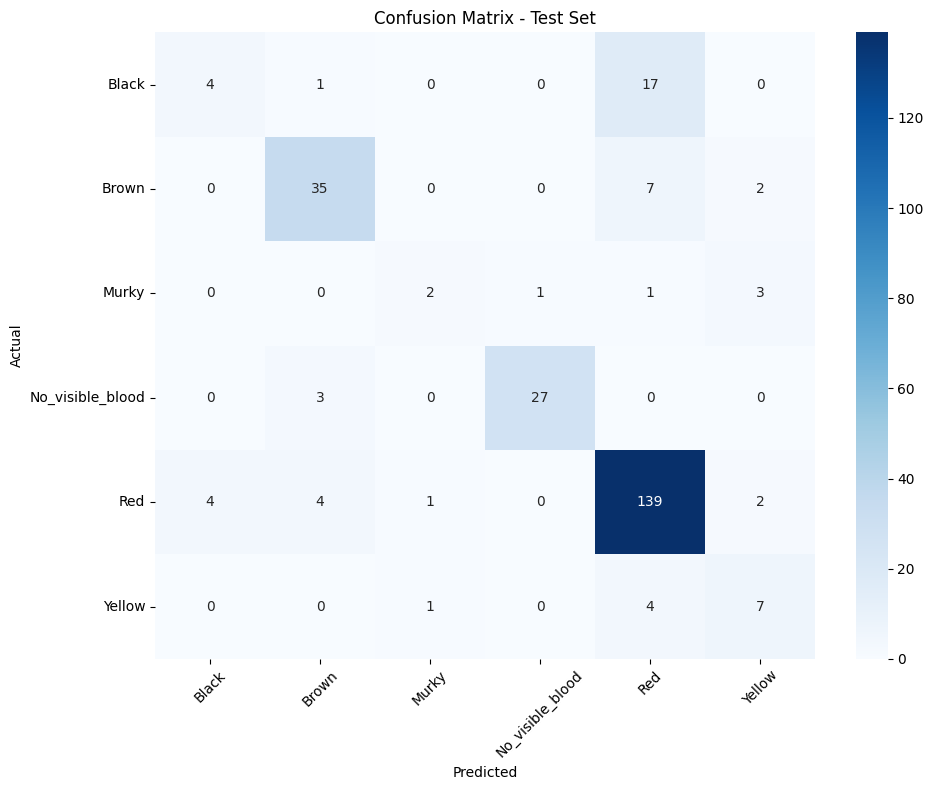

In [29]:
# Confusion Matrix for test set
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_int, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()